In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import yaml
from yaml import Loader
from itertools import product
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
from velocileptors.LPT.cleft_fftw import CLEFT
from velocileptors.EPT.cleft_kexpanded_resummed_fftw import RKECLEFT
from scipy.signal import savgol_filter
from scipy.interpolate import splrep, splev
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import h5py as h5
import sys
sys.path.append('/global/homes/j/jderose/project/ZeNBu/')
from zenbu_rsd import Zenbu_RSD
from zenbu import Zenbu
from Utils.spherical_bessel_transform_fftw import SphericalBesselTransform
from Utils.qfuncfft import QFuncFFT
from Utils.loginterp import loginterp

plt.rcParams['figure.figsize']        = 10., 10.
plt.rcParams['figure.dpi']            = 100
plt.rcParams['figure.subplot.left']   = 0.125
plt.rcParams['figure.subplot.right']  = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 16
plt.rcParams['axes.titlesize']        = 16
plt.rcParams['legend.frameon']        = True
plt.rcParams['legend.fancybox']        = True
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 16
plt.rcParams['ytick.labelsize']       = 16
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = True
plt.rcParams['font.family']           = 'serif'
#plt.rcParams['font.serif']            = 'Computer Modern Roman Bold'
plt.rcParams['font.size']             = 16


def _cleft_pk(k, p_lin, D=None, cleftobj=None, kecleft=True):
    '''
    Returns a spline object which computes the cleft component spectra.
    Computed either in "full" CLEFT or in "k-expanded" CLEFT (kecleft)
    which allows for faster redshift dependence.
    Args:
        k: array-like
            Array of wavevectors to compute power spectra at (in h/Mpc).
        p_lin: array-like
            Linear power spectrum to produce velocileptors predictions for.
            If kecleft==True, then should be for z=0, and redshift evolution is
            handled by passing the appropriate linear growth factor to D.
        D: float
            Linear growth factor. Only required if kecleft==True.
        kecleft: bool
            Whether to use kecleft or not. Setting kecleft==True
            allows for faster computation of spectra keeping cosmology
            fixed and varying redshift if the cleftobj from the
            previous calculation at the same cosmology is provided to
            the cleftobj keyword.
    Returns:
        cleft_aem : InterpolatedUnivariateSpline
            Spline that computes basis spectra as a function of k.
        cleftobt: CLEFT object
            CLEFT object used to compute basis spectra.
    '''

    if kecleft:
        if D is None:
            raise(ValueError('Must provide growth factor if using kecleft'))

        # If using kecleft, check if we're only varying the redshift

        if cleftobj is None:
            # Function to obtain the no-wiggle spectrum.
            # Not implemented yet, maybe Wallisch maybe B-Splines?
            # pnw = p_nwify(pk)
            # For now just use Stephen's standard savgol implementation.
            cleftobj = RKECLEFT(k, p_lin)

        # Adjust growth factors
        cleftobj.make_ptable(D=D, kmin=k[0], kmax=k[-1], nk=1000)
        cleftpk = cleftobj.pktable.T

    else:
        # Using "full" CLEFT, have to always do calculation from scratch
        cleftobj = CLEFT(k, p_lin, N=2700, jn=10, cutoff=1)
        cleftobj.make_ptable()

        cleftpk = cleftobj.pktable.T

        # Different cutoff for other spectra, because otherwise different
        # large scale asymptote

        cleftobj = CLEFT(k, p_lin, N=2700, jn=5, cutoff=10)
        cleftobj.make_ptable()

    cleftpk[3:, :] = cleftobj.pktable.T[3:, :]
    cleftpk[2, :] /= 2
    cleftpk[6, :] /= 0.25
    cleftpk[7, :] /= 2
    cleftpk[8, :] /= 2

    cleftspline = interp1d(cleftpk[0], cleftpk, fill_value='extrapolate')#, kind='cubic')

    return cleftspline, cleftobj



def _lpt_pk(k, p_lin, f, cleftobj=None, kecleft=False, zenbu=True, 
            third_order=True, one_loop=True, cutoff=np.pi*700/525.,
            jn=15, N=2700, nmax=8, ngauss=3):
    '''
    Returns a spline object which computes the cleft component spectra.
    Computed either in "full" CLEFT or in "k-expanded" CLEFT (kecleft)
    which allows for faster redshift dependence.
    Args:
        k: array-like
            Array of wavevectors to compute power spectra at (in h/Mpc).
        p_lin: array-like
            Linear power spectrum to produce velocileptors predictions for.
            If kecleft==True, then should be for z=0, and redshift evolution is
            handled by passing the appropriate linear growth factor to D.
        D: float
            Linear growth factor. Only required if kecleft==True.
        kecleft: bool
            Whether to use kecleft or not. Setting kecleft==True
            allows for faster computation of spectra keeping cosmology
            fixed and varying redshift if the cleftobj from the
            previous calculation at the same cosmology is provided to
            the cleftobj keyword.
    Returns:
        cleft_aem : InterpolatedUnivariateSpline
            Spline that computes basis spectra as a function of k.
        cleftobt: CLEFT object
            CLEFT object used to compute basis spectra.
    '''
    
    if not zenbu:
        lpt = LPT_RSD(k, p_lin, kIR=0.2, cutoff=cutoff,
                              extrap_min=-4, extrap_max = 3,
                              threads=1, jn=jn, third_order=third_order,
                             one_loop=one_loop)
        lpt.make_pltable(f, kv=k, nmax=4, 
                         apar=1, aperp=1)
    else:
        lpt  = Zenbu_RSD(k, p_lin, jn=jn, N=N, cutoff=cutoff)
        lpt.make_pltable(f, kv=k, nmax=nmax, ngauss=ngauss)
        
    p0table = lpt.p0ktable
    p2table = lpt.p2ktable
    p4table = lpt.p4ktable
    
    if not zenbu:
        p0table[:, 1] /= 2
        p0table[:, 5] /= 0.25
        p0table[:, 6] /= 2
        p0table[:, 7] /= 2    
#    
        p2table[:,1] /= 2
        p2table[:,5] /= 0.25
        p2table[:,6] /= 2
        p2table[:,7] /= 2   
#    
        p4table[:,1] /= 2
        p4table[:,5] /= 0.25
        p4table[:,6] /= 2
        p4table[:,7] /= 2  
    
    pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
    pktable[:,0,:] = p0table
    pktable[:,1,:] = p2table
    pktable[:,2,:] = p4table

    pellspline = interp1d(k, pktable.T, fill_value='extrapolate')#, kind='cubic')
    p0spline = interp1d(k, p0table.T, fill_value='extrapolate')#, kind='cubic')
    p2spline = interp1d(k, p2table.T, fill_value='extrapolate')#, kind='cubic')
    p4spline = interp1d(k, p4table.T, fill_value='extrapolate')#, kind='cubic')


    return lpt, p0spline, p2spline, p4spline, pellspline 


def _realspace_lpt_pk(k, p_lin, D=None, cleftobj=None, kecleft=False, zenbu=True, cutoff=np.pi*700/525.):
    '''
    Returns a spline object which computes the cleft component spectra.
    Computed either in "full" CLEFT or in "k-expanded" CLEFT (kecleft)
    which allows for faster redshift dependence.
    Args:
        k: array-like
            Array of wavevectors to compute power spectra at (in h/Mpc).
        p_lin: array-like
            Linear power spectrum to produce velocileptors predictions for.
            If kecleft==True, then should be for z=0, and redshift evolution is
            handled by passing the appropriate linear growth factor to D.
        D: float
            Linear growth factor. Only required if kecleft==True.
        kecleft: bool
            Whether to use kecleft or not. Setting kecleft==True
            allows for faster computation of spectra keeping cosmology
            fixed and varying redshift if the cleftobj from the
            previous calculation at the same cosmology is provided to
            the cleftobj keyword.
    Returns:
        cleft_aem : InterpolatedUnivariateSpline
            Spline that computes basis spectra as a function of k.
        cleftobt: CLEFT object
            CLEFT object used to compute basis spectra.
    '''

    if kecleft:
        if D is None:
            raise(ValueError('Must provide growth factor if using kecleft'))

        # If using kecleft, check if we're only varying the redshift

        if cleftobj is None:
            # Function to obtain the no-wiggle spectrum.
            # Not implemented yet, maybe Wallisch maybe B-Splines?
            # pnw = p_nwify(pk)
            # For now just use Stephen's standard savgol implementation.
            cleftobj = RKECLEFT(k, p_lin)

        # Adjust growth factors
        cleftobj.make_ptable(D=D, kmin=k[0], kmax=k[-1], nk=1000)
        cleftpk = cleftobj.pktable.T
        
    elif zenbu:
#        print(k.shape)
#        print(p_lin.shape)
        zobj = Zenbu(k, p_lin, cutoff=cutoff, N=3000, jn=15)
        zobj.make_ptable(kvec=k)
        cleftpk = zobj.pktable.T
        cleftobj = zobj
#        print(cleftpk.shape)
        

    else:
        # Using "full" CLEFT, have to always do calculation from scratch
        cleftobj = CLEFT(k, p_lin, N=2700, jn=10, cutoff=1)
        cleftobj.make_ptable()

        cleftpk = cleftobj.pktable.T

        # Different cutoff for other spectra, because otherwise different
        # large scale asymptote

        cleftobj = CLEFT(k, p_lin, N=2700, jn=5, cutoff=10)
        cleftobj.make_ptable()

    if not zenbu:
        cleftpk[2, :] /= 2
        cleftpk[6, :] /= 0.25
        cleftpk[7, :] /= 2
        cleftpk[8, :] /= 2

    cleftspline = interp1d(cleftpk[0], cleftpk, fill_value='extrapolate')#, kind='cubic')

    return cleftspline, cleftobj#, cleftpk

def load_pk_from_dict(input_data, get_nmodes=False):
    
    try:
        pk_ij_list = np.load(input_data, allow_pickle=True)
    except:
        pk_ij_list = input_data
        
    nspec = len(pk_ij_list)
    keys = list(pk_ij_list[0].keys())
    k = pk_ij_list[0]['k']
    nk = k.shape[0]
    
    if 'mu' in keys:
        mu = pk_ij_list[0]['mu']  
        nmu = mu.shape[-1]
    else:
        nmu = 1
        mu = None
    
    if 'power_poles' in keys:
        npoles = pk_ij_list[0]['power_poles'].shape[0]
        has_poles = True
        pk_pole_array = np.zeros((nspec, npoles, nk))
        
    else:
        npoles = 1
        has_poles = False
        
    pk_wedge_array = np.zeros((nspec, nk, nmu))
        
    for i in range(nspec):
#        print(pk_ij_list[i]['shotnoise'])
        #power_wedges is always defined, even if only using 1d pk (then wedge is [0,1])
        pk_wedges = pk_ij_list[i]['power_wedges']
        pk_wedge_array[i,...] = pk_wedges.reshape(nk,-1)
        
        if has_poles:
            pk_poles = pk_ij_list[i]['power_poles']
            pk_pole_array[i,...] = pk_poles
            nmodes = pk_ij_list[i]['nmodes']
        
    if has_poles:
        if get_nmodes:
            return k, mu, pk_wedge_array, pk_pole_array, nmodes
        else:
            return k, mu, pk_wedge_array, pk_pole_array
            
    else:
        return k, mu, pk_wedge_array
    
def get_spectra_from_fields(fields1, fields2, neutrinos=True):
    spectra = []
    for i, fi in enumerate(fields1):
        for j, fj in enumerate(fields2):
            if (i<j) | (neutrinos & (i==1) & (j==0)): continue
            spectra.append((fi, fj))
                      
    return spectra

def combine_real_space_spectra(k, spectra, bias_params, cross=False, numerical_nabla=False):

    pkvec = np.zeros((14, spectra.shape[1]))
    if numerical_nabla:
        pkvec[...] = spectra[:14]
    else:
        pkvec[:10, ...] = spectra[:10]
        # IDs for the <nabla^2, X> ~ -k^2 <1, X> approximation.
        nabla_idx = [0, 1, 3, 6]

        # Higher derivative terms
        pkvec[10:, ...] = -k[np.newaxis, :]**2 * pkvec[nabla_idx, ...]

    b1, b2, bs, bk2, sn = bias_params
    if not cross:
        bterms = [1,
                  2*b1, b1**2,
                  b2, b2*b1, 0.25*b2**2,
                  2*bs, 2*bs*b1, bs*b2, bs**2,
                  2*bk2, 2*bk2*b1, bk2*b2, 2*bk2*bs]
    else:
        # hm correlations only have one kind of <1,delta_i> correlation
        bterms = [1,
                  b1, 0,
                  b2/2, 0, 0,
                  bs, 0, 0, 0,
                  bk2, 0, 0, 0]

    p = np.einsum('b, bk->k', bterms, pkvec)

    if not cross:
        p += sn

    return p    

def combine_rsd_spectra(k, spectra_poles, bias_params, ngauss=3):

    pkvec = np.zeros((17, spectra_poles.shape[1], spectra_poles.shape[2]))
    pkvec[:10, ...] = spectra_poles[:10,...]
      
    b1,b2,bs,alpha0,alpha2,alpha4,alpha6,sn,sn2,sn4 = bias_params
    bias_monomials = np.array([1, 2*b1, b1**2, b2, b1*b2, 0.25*b2**2, 2*bs, 2*b1*bs, b2*bs, bs**2, alpha0, alpha2, alpha4,alpha6,sn,sn2,sn4])
    
    nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
    nus_calc = nus[0:ngauss]
    nus = nus[0:ngauss]
    ws = ws[:ngauss]
    n_nu = ngauss
    leggauss = True
        
    L0 = np.polynomial.legendre.Legendre((1))(nus)
    L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
    L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)        
        
    pk_stoch = np.zeros((3, n_nu, spectra_poles.shape[2]))    
    
    pk_stoch[0,:,:] = 1
    pk_stoch[1,:,:] = k[np.newaxis,:]**2 * nus[:, np.newaxis]**2 
    pk_stoch[2,:,:] = k[np.newaxis,:]**4 * nus[:, np.newaxis]**4
    
    pkvec[14:,0,...] = 0.5 * np.sum((ws*L0)[np.newaxis,:ngauss,np.newaxis]*pk_stoch,axis=1)
    pkvec[14:,1,...] = 2.5 * np.sum((ws*L2)[np.newaxis,:ngauss,np.newaxis]*pk_stoch,axis=1)
    pkvec[14:,2,...] = 4.5 * np.sum((ws*L4)[np.newaxis,:ngauss,np.newaxis]*pk_stoch,axis=1) 
    
    p0 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,0,:], axis=0)
    p2 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,1,:], axis=0)
    p4 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,2,:], axis=0)
    

    return p0, p2, p4

def combine_rsd_cross_spectra(k, spectra_poles, bias_params, ngauss=3):

    pkvec = np.zeros((5, spectra_poles.shape[1], spectra_poles.shape[2]))
    pkvec[:5, ...] = spectra_poles[:5,...]
      
    b1,b2,bs,alpha0,alpha2,alpha4,alpha6,sn,sn2,sn4 = bias_params
    bias_monomials = np.array([1, b1, 0.5 * b2, bs, alpha0])
     
    p0 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,0,:], axis=0) #+ sn
    p2 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,1,:], axis=0) #+ sn2
    p4 = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,2,:], axis=0) #+ sn4
    

    return p0, p2, p4

def combine_real_space_cross_spectra(k, spectra_poles, bias_params):

    pkvec = np.zeros((5, spectra_poles.shape[1]))
    pkvec[:5, ...] = spectra_poles[:5,...]

    b1,b2,bs,bk,sn = bias_params
    bias_monomials = np.array([1, b1, 0.5 * b2, bs, bk])

    pk = np.sum(bias_monomials[:,np.newaxis] * pkvec[:,:], axis=0) + sn

    return pk


def combine_spectra(k, spectra, bias_params, rsd=False):
    
    if rsd:
        p0, p2, p4 = combine_rsd_spectra(k, spectra, bias_params)
        pk = np.stack([p0, p2, p4])
    else:
        pk = combine_real_space_spectra(k, spectra, bias_params)
        
    return pk

def combine_cross_spectra(k, spectra, bias_params, rsd=False):
    
    if rsd:
        p0, p2, p4 = combine_rsd_cross_spectra(k, spectra, bias_params)
        pk = np.stack([p0, p2, p4])
    else:
        pk = combine_real_space_cross_spectra(k, spectra, bias_params)
        
    return pk
                      

def multipole_cov(pell, ell):
    
    if ell==0:
        cov = 2 * pell[0,:]**2 + 2/5 * pell[1,:]**2 + 2/9 * pell[2,:]**2
        
    elif ell==2:
        cov = 2/5 * pell[0,:]**2 + 6/35 * pell[1,:]**2 + 3578/45045 * pell[2,:]**2 \
               + 8/35 * pell[0,:] * pell[1,:] + 8/35 * pell[0,:] * pell[2,:] + 48/385 * pell[1,:] * pell[2,:]

    elif ell==4:
        cov = 2/9 * pell[0,:]**2 + 3578/45045 * pell[1,:]**2 + 1058/17017 * pell[2,:]**2 \
               + 80/693 * pell[0,:] * pell[1,:] + 72/1001 * pell[0,:] * pell[2,:] + 80/1001 * pell[1,:] * pell[2,:]
        
    return cov

def deconvolve_window(poles, window_inv, npoles=3):

    nk_win = window_inv.shape[0]//npoles
    if len(poles.shape)>2:
        poles_deconv = np.zeros((poles.shape[0],npoles,nk_win))
        for i in range(poles.shape[0]):
            poles_d = np.hstack(poles[i,:,:nk_win])
            poles_d = np.dot(window_inv, poles_d).reshape(3,-1)
            poles_deconv[i,...] = poles_d
    else:
        poles_deconv = np.hstack(poles[:,:nk_win])
        poles_deconv = np.dot(window_inv, poles_deconv).reshape(3,-1)

    return poles_deconv

def compute_beta_and_reduce_variance_tt(k, pk_nn, pk_ij_zn, pk_ij_zz, pk_ij_zb, 
                                        bias_vec, window=None, kin=None, kout=None, 
                                        s_ell=[0.1, 10, 100], sg_window=21, rsd=False,
                                        k0=0.618, dk=0.167, deconv=False, beta1_k=0.05):
    
    fields_z = ['1', 'd', 'd2', 's', 'n2']
    fields_zenbu = ['1', 'd', 'd2', 's']
    
    if deconv & (window is not None):
        pk_nn = deconvolve_window(pk_nn, np.linalg.inv(window).T)
        pk_ij_zn = deconvolve_window(pk_ij_zn, np.linalg.inv(window).T)
        pk_ij_zz = deconvolve_window(pk_ij_zz, np.linalg.inv(window).T)
        k = np.copy(k)
        k = k[:len(window)//3]
        pk_ij_zb = np.copy(pk_ij_zb)
        pk_ij_zb = pk_ij_zb[...,:len(window)//3]
    
    component_spectra_zz = get_spectra_from_fields(fields_z, fields_z, neutrinos=False)
    pk_ij_zz_dict = dict(zip(component_spectra_zz, pk_ij_zz))
    nspec = len(bias_vec)

    if rsd:
        if len(bias_vec)<11:
            bias_vec = np.hstack([bias_vec, np.zeros(11-len(bias_vec))])
            
    else:
        if len(bias_vec)<6:
            bias_vec = np.hstack([bias_vec, np.zeros(6-len(bias_vec))])        
    
    # first element of bias vec should always be one, so don't pass this 
    # to our usual component spectra summation functions

    pk_zz = combine_spectra(k, pk_ij_zz, bias_vec[1:], rsd=rsd)
    if kin is not None:
        pk_zenbu = combine_spectra(kin, pk_ij_zb, bias_vec[1:], rsd=rsd)
    else:
        pk_zenbu = combine_spectra(k, pk_ij_zb, bias_vec[1:], rsd=rsd)
        
    pk_zn = combine_cross_spectra(k, pk_ij_zn, bias_vec[1:], rsd=rsd)

    if rsd:
        cov_zn = np.stack([multipole_cov(pk_zn, ell) for ell in [0,2,4]])
        var_zz = np.stack([multipole_cov(pk_zz, ell) for ell in [0,2,4]])
        var_nn = np.stack([multipole_cov(pk_nn, ell) for ell in [0,2,4]])
    else:
        cov_zn = 2 * pk_zn ** 2
        var_zz = 2 * pk_zz ** 2
        var_nn = 2 * pk_nn ** 2
    
    beta = cov_zn / var_zz
    beta_damp = 1/2 * (1 - np.tanh((k - k0)/dk)) * beta

    r_zt = cov_zn / np.sqrt(var_zz * var_nn)
    beta_damp = np.atleast_2d(beta_damp)
    beta_damp[beta_damp != beta_damp] = 0
    beta_damp[:,:k.searchsorted(beta1_k)] = 1
    
    r_zt = np.atleast_2d(r_zt)
    r_zt[r_zt != r_zt] = 0

    beta_smooth = np.zeros_like(beta_damp)
    beta_smooth_nohex = np.zeros_like(beta_damp)
    
    for i in range(beta_smooth.shape[0]):

        beta_smooth[i,:] = savgol_filter(beta_damp.T[:,i], sg_window, 3) #splev(k, betaspl)    
        if i!=2:
            beta_smooth_nohex[i,:] = savgol_filter(beta_damp.T[:,i], sg_window, 3)#splev(k, betaspl)  
        else:
            beta_smooth_nohex[i,:] = 1
            
    r_zt_smooth = np.zeros_like(r_zt)
    r_zt_smooth_nohex = np.zeros_like(r_zt)

    for i in range(r_zt.shape[0]):
        spl = splrep(k, r_zt.T[:,i], s=s_ell[i])
        r_zt_smooth[i,:] = splev(k, spl)  #savgol_filter(r_zt.T[:,i], sg_window, 3)#splev(k, spl)    
        if i<1:
            r_zt_smooth_nohex[i,:] = splev(k, spl)  #savgol_filter(r_zt.T[:,i], sg_window, 3)#splev(k, spl)  
        else:
            r_zt_smooth_nohex[i,:] = 1
            
    if (window is not None) & (not deconv):

        pk_zenbu = np.hstack(pk_zenbu)
        pk_zenbu = np.dot(window.T, pk_zenbu).reshape(3,-1)
    
    pk_nn_hat = pk_nn - beta_damp * (pk_zz - pk_zenbu)
    pk_nn_betasmooth = pk_nn - beta_smooth * (pk_zz - pk_zenbu)
    pk_nn_betasmooth_nohex = pk_nn - beta_smooth * (pk_zz - pk_zenbu)
    pk_nn_beta1 = pk_nn - (pk_zz - pk_zenbu)
        
    return pk_nn_hat, pk_nn_betasmooth, pk_nn_betasmooth_nohex, pk_nn_beta1, beta, beta_damp, beta_smooth, beta_smooth_nohex, pk_zz, pk_zenbu, r_zt, r_zt_smooth, r_zt_smooth_nohex, pk_zn

def lpt_spectra(k, z, anzu_config, kin, pin, pkclass=None, zenbu=True, kmin=1e-3):
    
    if pkclass==None:
        with open(anzu_config, 'r') as fp:
            cfg = yaml.load(fp, Loader=Loader)
        pkclass = Class()
        pkclass.set(cfg["Cosmology"])
        pkclass.compute()
    else:
        with open(anzu_config, 'r') as fp:
            cfg = yaml.load(fp, Loader=Loader)        
    kt = np.logspace(1e-3,1,200)
    cutoff = np.pi * cfg['nmesh_in'] / cfg['lbox']
    kidx = kin.searchsorted(kmin)

    Dthis = pkclass.scale_independent_growth_factor(z)
    Dic = pkclass.scale_independent_growth_factor(cfg['z_ic'])
    pk_lin = np.array([pkclass.pk_lin(ki, np.array([z])) * cfg['Cosmology']['h']**3 for ki in kt * cfg['Cosmology']['h']])
    pk_cb_lin = np.array([pkclass.pk_cb_lin(ki, np.array([z])) * cfg['Cosmology']['h']**3 for ki in kt * cfg['Cosmology']['h']])

    
    f = pkclass.scale_independent_growth_factor_f(z)

    lptobj, p0spline, p2spline, p4spline, pellspline = _lpt_pk(kin[kidx:], pin[kidx:]*(Dthis/Dic)**2, f, cutoff=cutoff, third_order=False, one_loop=False, zenbu=zenbu)
    pk_zenbu = pellspline(k)

    cleftobj, p0spline_m, p2spline_m, p4spline_m, pellspline_m = _lpt_pk(kt, pk_lin, f, zenbu=False)
    cleftobj, p0spline_cb, p2spline_cb, p4spline_cb, pellspline_cb = _lpt_pk(kt, pk_cb_lin, f, zenbu=False)

    pk_m_3lpt = pellspline_m(k)
    pk_cb_3lpt = pellspline_cb(k)
        
    return pk_zenbu[:11], pk_m_3lpt[:11], pk_cb_3lpt[:11], pkclass #pk_zenbu[:11], pk_3lpt[:11], pkclass

def zenbu_spectra(k, z, anzu_config, kin, pin, pkclass=None, zenbu=True, N=2700, jn=15, rsd=True, nmax=6, ngauss=6):
    
    if pkclass==None:
        with open(anzu_config, 'r') as fp:
            cfg = yaml.load(fp, Loader=Loader)
        pkclass = Class()
        pkclass.set(cfg["Cosmology"])
        pkclass.compute()
    else:
        with open(anzu_config, 'r') as fp:
            cfg = yaml.load(fp, Loader=Loader)        
        
    kt = np.logspace(-3,1,400)

    try:
        cutoff = cfg['surrogate_gaussian_cutoff']
        if (cutoff == True):
            cutoff = np.pi * cfg['nmesh_in'] / cfg['lbox']
        else:
            cutoff = float(cfg['surrogate_gaussian_cutoff'])
    except Exception as e:
        cutoff = np.pi * cfg['nmesh_in'] / cfg['lbox']
        
    Dthis = pkclass.scale_independent_growth_factor(z)
    Dic = pkclass.scale_independent_growth_factor(cfg['z_ic'])
    f = pkclass.scale_independent_growth_factor_f(z)
    
    if rsd:
        lptobj, p0spline, p2spline, p4spline, pspline = _lpt_pk(kin, pin*(Dthis/Dic)**2, 
                                                               f, cutoff=cutoff, 
                                                               third_order=False, one_loop=False,
                                                               zenbu=zenbu, jn=jn, N=N, nmax=nmax, ngauss=ngauss)
        pk_zenbu = pspline(k)
        
    else:
        pspline, _ = _realspace_lpt_pk(kin, pin*(Dthis/Dic)**2)  
        pk_zenbu = pspline(k)[1:]

    return pk_zenbu[:11]

def reduce_variance_tt(k, pk_nn, pk_ij_zn, pk_ij_zz, anzu_config, z, bias_vec, window=None,
                       kin=None, kout=None, s_ell=[0.1, 10, 100],
                       sg_window=21, rsd=True, neutrinos=True,
                       pkclass=None, pk_ij_zenbu=None, deconv=False):

    p_in = np.genfromtxt('{}/input_powerspec.txt'.format('/'.join(anzu_config.split('/')[:-1])))
    kth, p_m_lin = p_in[:,0], p_in[:,1]*(2*np.pi)**3 
    if pk_ij_zenbu is None:
        if kin is not None:
            pk_ij_zenbu = zenbu_spectra(kin, z, anzu_config, kth, p_m_lin, pkclass=pkclass, rsd=rsd)
        else:
            pk_ij_zenbu = zenbu_spectra(k, z, anzu_config, kth, p_m_lin, pkclass=pkclass, rsd=rsd)
            
    pk_nn_hat, pk_nn_betasmooth, pk_nn_betasmooth_nohex, pk_nn_beta1, beta, beta_damp, beta_smooth, beta_smooth_nohex, pk_zz, pk_zenbu, r_zt, r_zt_smooth, r_zt_smooth_nohex, pk_zn = compute_beta_and_reduce_variance_tt(k, pk_nn, pk_ij_zn, pk_ij_zz, pk_ij_zenbu, bias_vec, window=window, kin=kin, kout=kout, s_ell=s_ell, rsd=rsd, k0=0.618, dk=0.167, sg_window=sg_window, deconv=deconv)
    return pk_nn_hat, pk_nn_betasmooth, pk_nn_betasmooth_nohex, pk_nn_beta1, beta, beta_damp, beta_smooth, beta_smooth_nohex, pk_zz, pk_zenbu, r_zt, r_zt_smooth, r_zt_smooth_nohex, pk_zn, pk_ij_zenbu, pkclass



In [2]:
def measure_2pt_bias_rsd(k, pk_ij_heft, pk_tt, kmax, ellmax=2, nbias=3):
    
    kidx = k.searchsorted(kmax)
    kcut = k[:kidx]
    pk_tt_kcut = pk_tt[:ellmax,:kidx]
    pk_ij_heft_kcut = pk_ij_heft[:,:,:kidx]
    bvec0 = [1, 0, 0]#, 0, 0]
    
    loss = lambda bvec : np.sum((pk_tt_kcut - combine_spectra(kcut, pk_ij_heft_kcut, np.hstack([bvec,np.zeros(10-len(bvec))]), rsd=True)[:ellmax,:])**2/(2 * pk_tt_kcut**2))
    #b1,b2,bs,alpha0,alpha2,alpha4,alpha6,sn,sn2,sn4
    
    out = minimize(loss, bvec0)
    
    return out

def measure_2pt_bias(k, pk_ij_heft, pk_tt, kmax, nbias=3):
    
    kidx = k.searchsorted(kmax)
    kcut = k[:kidx]
    pk_tt_kcut = pk_tt[:kidx]
    pk_ij_heft_kcut = pk_ij_heft[:,:kidx]
    bvec0 = [1, 0, 0, 0, 5000]

    loss = lambda bvec : np.sum((pk_tt_kcut - combine_spectra(kcut, pk_ij_heft_kcut, np.hstack([bvec,np.zeros(5-len(bvec))])))**2/(2 * pk_tt_kcut**2))
    #b1,b2,bs,alpha0,alpha2,alpha4,alpha6,sn,sn2,sn4
    
    out = minimize(loss, bvec0)
    
    return out


In [19]:
boxnum = 76
a_this = 0.6504
massbin = 0
basename = '/global/cfs/projectdirs/cosmosim/slac/jderose/aemulus_nu/Box{}_1400/anzu_fields_2xsmooth/'.format(boxnum)
configbase = '/global/cscratch1/sd/jderose/aemulus_nu_setup/Box{}_1400/run/'.format(boxnum)

anzu_config = configbase + 'anzu_fields.param'
with open(anzu_config, 'r') as fp:
    cfg = yaml.load(fp, Loader=Loader)
pk_tt_fname = basename + 'outbgc2_10_massbin_{}.h5_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(massbin, a_this)
pk_zz_fname = basename + 'zcv_surrogate_auto_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
pk_zt_fname = basename + 'zcv_cross_outbgc2_10_massbin_{}.h5_pk_rsd=True_pypower=True_a{:.4f}_nmesh1400.npy'.format(massbin, a_this)

pk_tt_rs_fname = basename + 'outbgc2_10_massbin_{}.h5_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(massbin, a_this)
pk_zz_rs_fname = basename + 'zcv_surrogate_auto_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(a_this)
pk_zt_rs_fname = basename + 'zcv_cross_outbgc2_10_massbin_{}.h5_pk_rsd=False_pypower=True_a{:.4f}_nmesh1400.npy'.format(massbin, a_this)

m=0

z_this = 1/a_this - 1
k, mu, _, pk_tt_poles = load_pk_from_dict(pk_tt_fname)
k, mu, _, pk_ij_zz_poles = load_pk_from_dict(pk_zz_fname)
k, mu, _, pk_ij_zt_poles = load_pk_from_dict(pk_zt_fname)

k, mu, pk_tt, _ = load_pk_from_dict(pk_tt_rs_fname)
k, mu, pk_ij_zz, _ = load_pk_from_dict(pk_zz_rs_fname)
k, mu, pk_ij_zt, _ = load_pk_from_dict(pk_zt_rs_fname)

p_in = np.genfromtxt('{}/input_powerspec.txt'.format('/'.join(anzu_config.split('/')[:-1])))
kth, p_m_lin = p_in[:,0], p_in[:,1]*(2*np.pi)**3 

#pk_zb, pk_3lpt, pk_3lpt_cb, pkclass = lpt_spectra(k, z_this, anzu_config, kth, p_m_lin, pkclass=None)

In [22]:
bvec_opt = measure_2pt_bias_rsd(k, pk_ij_zz_poles[:,:,:], pk_tt_poles[0,:,:], 0.15, ellmax=1)
bvec_opt_rs = measure_2pt_bias(k, pk_ij_zz[:,:,0], pk_tt[0,:,0], 0.15)

In [23]:
print(bvec_opt['x'])
print(bvec_opt_rs['x'])
#print(b_full)

[ 1.12434234  3.02656682 -2.52808984]
[ 1.07034208e+00  6.99307833e-01 -3.67906490e-01 -1.45682139e-01
  5.00000088e+03]


In [24]:
window = np.loadtxt('window_nmesh350.npy')
kin = np.loadtxt('kin_window_nmesh350.npy')
kout = np.loadtxt('kout_window_nmesh350.npy')

In [25]:
i=2
bias_vec = [1, *bvec_opt_rs['x'][:i]]
pk_nn_hat, pk_nn_betasmooth, pk_nn_betasmooth_nohex,\
pk_nn_beta1, beta, beta_damp, beta_smooth, \
beta_smooth_nohex, pk_zz, pk_zenbu, r_zt, r_zt_smooth,\
r_zt_smooth_nohex, pk_zn, pk_ij_zenbu_poles, pkclass = reduce_variance_tt(k, pk_tt_poles[0,...], pk_ij_zt_poles,\
                                                                          pk_ij_zz_poles, anzu_config, z_this,\
                                                                          bias_vec, rsd=True)#, window=window, kin=kin)#, pk_ij_zenbu=pk_ij_zenbu_poles)


/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:377: RuntimeWarning: overflow encountered in multiply
  bias_integrands = bias_integrands * expon * (-2./k/self.qint)**l
/global/homes/j/jderose/project/ZeNBu/Utils/spherical_bessel_transform_fftw.py:102: RuntimeWarning: invalid value encountered in multiply
  self.gks[:] = np.conj(fks * self.udict[nu])
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:301: RuntimeWarning: overflow encountered in exp
  expon = np.exp(-0.5*Ksq * D2* (self.XYlin - self.sigma))
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:302: RuntimeWarning: overflow encountered in expm1
  exponm1 = np.expm1(-0.5*Ksq * D2* (self.XYlin - self.sigma))
/global/homes/j/jderose/project/ZeNBu/zenbu_rsd.py:374: RuntimeWarning: overflow encountered in multiply
  bias_integrands = bias_integran

(0.0, 0.5)

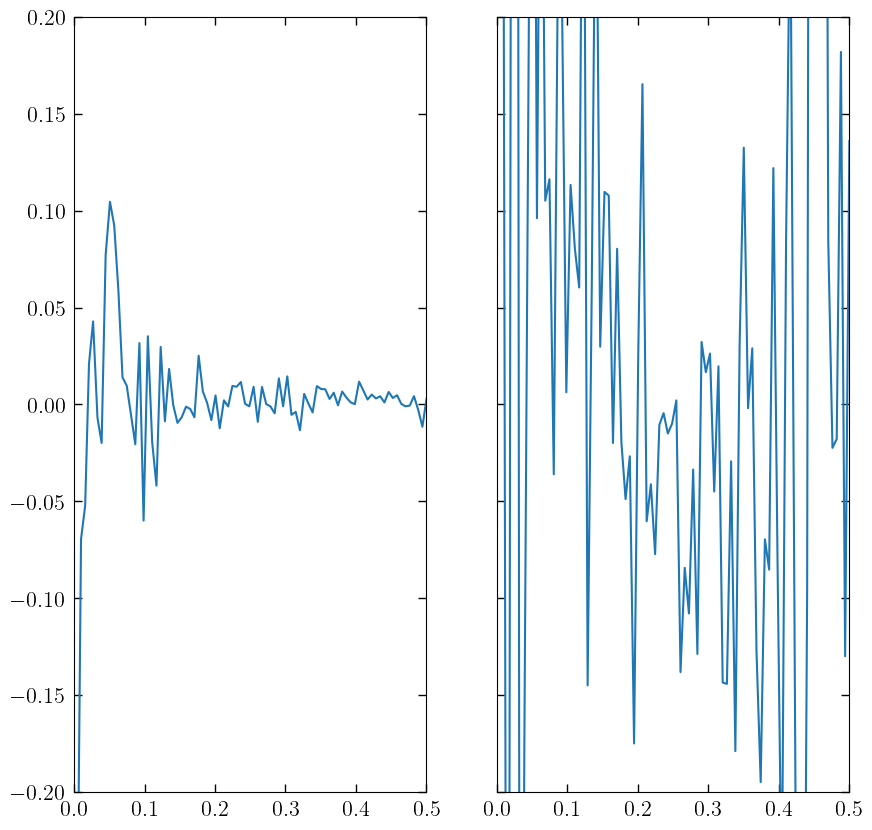

In [26]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True)
sidx = 0
for ell in range(2):
    ax[ell].plot(k, pk_zz[ell,:]/pk_zenbu[ell,:] - 1)
ax[0].set_ylim([-0.2, 0.2])
ax[0].set_xlim([0, 0.5])

(-100.0, 3000.0)

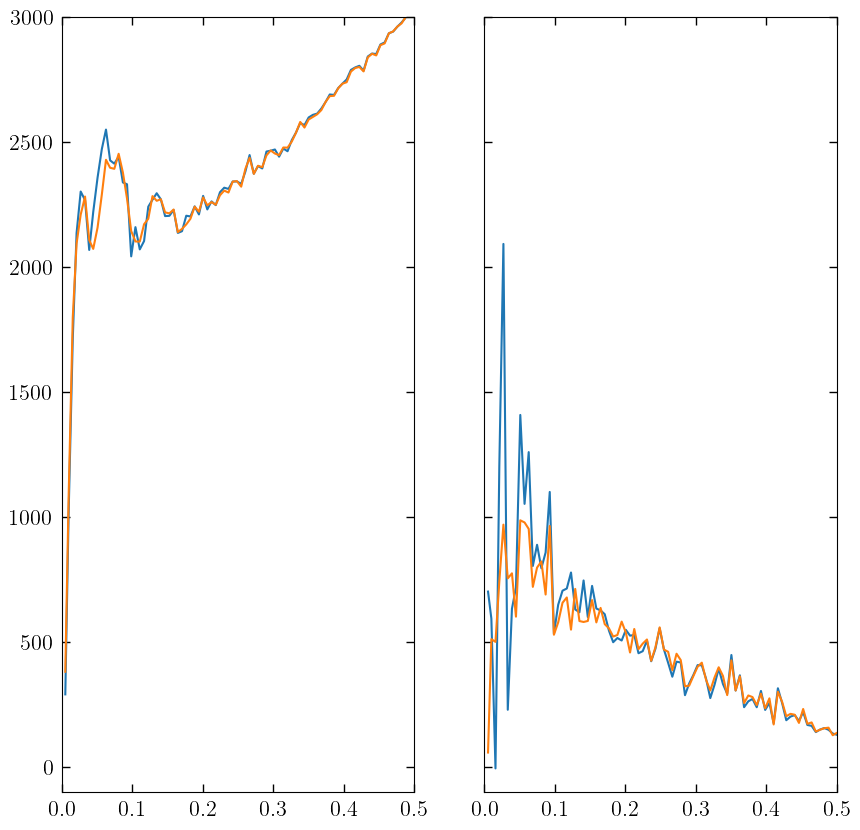

In [27]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True)

for ell in range(2):
    ax[ell].plot(k, k * pk_tt_poles[0,ell,:])   
    ax[ell].plot(k, k * pk_nn_betasmooth[ell,:])
ax[0].set_xlim([0, 0.5])
ax[0].set_ylim([-100, 3000])